# Amazon Grocery Data - Cleaning and Preprocessing

 In this project, we are performing data cleaning and preprocessing on a dataset containing Amazon grocery product information.
 
We will handle missing values, remove duplicates, preprocess text data, and ensure the dataset is ready for further analysis.

**Let's get started by importing the required libraries and loading the data.**

In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import numpy as np
from fuzzywuzzy import process, fuzz
from pprint import pprint
import itertools

# Load the dataset
data = pd.read_csv("old_data.csv")

# Display the shape of the dataset (rows, columns)
data.shape

(6341, 20)

# Data Pre-processing

**Step 1: Handling Duplicates**

First, we will check for duplicates based on the ASIN (Amazon Standard Identification Number) column and remove them.


In [2]:
# Remove duplicates based on 'ASIN', keeping the first occurrence
data = data.drop_duplicates(subset="ASIN", keep="first")

**Step 2: Checking Missing Values and Data Types**
 
We'll check for missing values and the data types of the columns to identify areas that need cleaning.


In [3]:
# Check for missing values and data types in the dataset
missing_values = data.isnull().sum()
data_types = data.dtypes

# Combine missing values and data types into a single DataFrame
missing_data_summary = pd.DataFrame({
    'Data Type': data_types,
    'Missing Values': missing_values,
    'Percentage Missing': (missing_values / len(data) * 100).round(2)
})

# Display the summary sorted by missing values in descending order
missing_data_summary = missing_data_summary[missing_data_summary['Missing Values'] > 0]
missing_data_summary = missing_data_summary.sort_values(by='Missing Values', ascending=False)

# Display the summary table
print("Missing Values and Data Types Summary:")
print(missing_data_summary)


Missing Values and Data Types Summary:
                 Data Type  Missing Values  Percentage Missing
FBA Fees           float64            2177               42.93
Sales               object            1572               31.00
Buy Box             object            1566               30.88
Revenue             object            1292               25.48
Size Tier           object            1291               25.46
Dimensions          object            1278               25.20
Weight             float64            1208               23.82
Price              float64            1072               21.14
Delivery            object             913               18.00
Review Count       float64             750               14.79
Ratings            float64             750               14.79
Images             float64             460                9.07
BSR                 object             413                8.14
Active Sellers #   float64              51                1.01
Review velocity 

**Step 3: Preprocessing Brand Names**

We'll clean the brand names to ensure consistency using text preprocessing. This involves converting text to lowercase, removing punctuation, and eliminating stopwords (common words that don't add much meaning).


In [4]:
# Get a list of unique brand names
data['Brand'] = data['Brand'].replace(['NA', 'null', ''], np.nan)
unique_brands = data['Brand'].dropna().unique()
unique_brands = pd.Series(unique_brands)

# Preprocessing function for text data
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Apply preprocessing to unique brand names
processed_brands = unique_brands.apply(preprocess_text)
processed_brands = processed_brands.unique()

**Step 4: Fuzzy Matching for Brand Names**
 
Fuzzy matching will help us identify similar brand names that may be inconsistently written (e.g., "Nestle" vs. "Nestlé"). We'll find potential matches and replace them with the shortest, most consistent version.


In [5]:
# Ensure unique_brands is a list
unique_brands = list(processed_brands)

# Dictionary to hold potential fuzzy matches
potential_matches = {}

# Find fuzzy matches for each brand
for brand in unique_brands:
    matches = process.extract(brand, unique_brands, limit=10, scorer=fuzz.ratio)
    potential_matches[brand] = [match[0] for match in matches if match[1] >= 80 and match[0] != brand]

# Filter out brands that don't have any close matches
filtered_matches = {brand: matches for brand, matches in potential_matches.items() if matches}

# Display only the first 5 brands with potential matches
print("Example of Brands with Potential Fuzzy Matches:\n")
for brand, matches in itertools.islice(filtered_matches.items(), 5):
    print(f"Brand: {brand}")
    print("Potential Matches:")
    for match in matches:
        print(f"  - {match}")
    print() 


Example of Brands with Potential Fuzzy Matches:

Brand: dragonfly teas
Potential Matches:
  - dragonfly tea

Brand: dragonfly tea
Potential Matches:
  - dragonfly teas
  - dragonfly

Brand: limca
Potential Matches:
  - lima

Brand: twinings
Potential Matches:
  - itc twinings

Brand: rounton coffee
Potential Matches:
  - union coffee



**Step 5: Replacing Inconsistent Brand Names**

**Now, we'll map inconsistent brand names to the shortest common version across all their variations.**


In [6]:
# Create a dictionary to hold the replacements
brand_replacements = {}

# Replace each matched brand with the shortest version
for brand, matches in filtered_matches.items():
    all_matches = [brand] + matches
    shortest_match = min(all_matches, key=len)
    for match in all_matches:
        brand_replacements[match] = shortest_match


# Replace common representations of nulls
data['Brand'] = data['Brand'].replace(['NA', 'null', ''], np.nan)
data['Brand'] = data['Brand'].astype(str).apply(preprocess_text)
# Apply the replacements to the original data
data['Brand'] = data['Brand'].replace(brand_replacements)
data['Brand'] = data['Brand'].fillna('Unknown')
# Capitalise Brand names
data['Brand'] = data['Brand'].str.title()

# Display last 5 examples of replacements
print("Examples of Brand Replacements:\n")
for original, replacement in itertools.islice(reversed(list(brand_replacements.items())), 10):
    print(f"Original: {original} -> Replacement: {replacement}")
    

Examples of Brand Replacements:

Original: wufuyuan -> Replacement: wufuyuan
Original: wu fu yuan -> Replacement: wufuyuan
Original: wilkin sons -> Replacement: wilkin sons
Original: wilkin sons ltd -> Replacement: wilkin sons
Original: wholefood earth -> Replacement: whole earth
Original: whole earth -> Replacement: whole earth
Original: weight watchers -> Replacement: weight watchers
Original: weight watchers heinz -> Replacement: weight watchers
Original: vitacoco -> Replacement: vitacoco
Original: vita coco -> Replacement: vitacoco


**Step 6: Handling Missing Values**

Now, we’ll deal with missing values for key columns like Brand, Price, Sales, Revenue, and Ratings.


In [7]:
# Drop rows where all of 'Brand', 'Price', 'Sales', 'Revenue', 'Ratings', 'Review Count', and 'Buy Box' are missing
data = data.dropna(subset=['Price', 'Sales', 'Revenue', 'Ratings', 'Review Count', 'Buy Box'], how='all')

# Drop rows where all of 'Price', 'Sales', 'Revenue' are missing
data = data.dropna(subset=['Price', 'Sales', 'Revenue'],how='all')
                        


**Step 7: Cleaning and Converting to Numeric**

We'll clean and convert relevant columns (e.g., Sales, Price, Revenue) into numeric data types to facilitate further analysis.


In [8]:
# Function to clean and convert columns to numeric
def clean_and_convert_to_numeric(series):
    return pd.to_numeric(series.astype(str).str.replace(',', ''), errors='coerce')

# Apply cleaning and conversion to relevant columns
data['Sales'] = clean_and_convert_to_numeric(data['Sales'])
data['Price'] = clean_and_convert_to_numeric(data['Price'])
data['Revenue'] = clean_and_convert_to_numeric(data['Revenue'])

**Step 8: Filling Missing Values**
 
We will impute missing values using various methods, such as filling missing prices with the median of the respective category and brand.


In [9]:
# Fill missing Price values with the median price for each brand within the category
median_price = data.groupby(['Category', 'Brand'])['Price'].transform('median')
data['Price'] = data['Price'].fillna(median_price)

# Fill any remaining missing Price values with the median of the category
median_price = data.groupby(['Category'])['Price'].transform('median')
data['Price'] = data['Price'].fillna(median_price)

# Removing any rows with any null price values
data = data.dropna(subset=['Price'])

**Step 9: Calculating Missing Sales and Revenue**
 
We will calculate Sales and Revenue if either one is missing but the other two (Price and either Sales or Revenue) are available.


In [10]:
# Calculate missing Sales based on Revenue and Price
data['Sales'] = np.where(
    pd.isnull(data['Sales']) & data['Revenue'].notnull() & data['Price'].notnull(),
    data['Revenue'] / data['Price'],  # Sales = Revenue / Price
    data['Sales']
)

# Calculate missing Revenue based on Sales and Price
data['Revenue'] = np.where(
    pd.isnull(data['Revenue']) & data['Sales'].notnull() & data['Price'].notnull(),
    data['Sales'] * data['Price'],  # Revenue = Sales * Price
    data['Revenue']
)

# Fill remaining missing Sales and Revenue with 0
data['Sales'] = data['Sales'].fillna(0)
data['Revenue'] = data['Revenue'].fillna(0)
data['BSR'] = data['BSR'].fillna(0)

**Step 10: Imputing Missing Values for Other Columns**
 
Now, we'll fill missing values for columns like 'Review Count', 'Ratings', and other relevant columns with their median values within each category.


In [11]:
# Clean and convert other relevant columns to numeric
data['Active Sellers #'] = clean_and_convert_to_numeric(data['Active Sellers #'])
data['Review Count'] = clean_and_convert_to_numeric(data['Review Count'])
data['Ratings'] = clean_and_convert_to_numeric(data['Ratings'])
data['Review velocity'] = clean_and_convert_to_numeric(data['Review velocity'])
data['Images'] = clean_and_convert_to_numeric(data['Images'])

# List of columns to impute with the median
columns_to_impute = ['Active Sellers #', 'Review Count', 'Ratings', 'Review velocity', 'Images']

# Impute missing values with the median for each category
for column in columns_to_impute:
    median_value = data.groupby(['Category'])[column].transform('median')
    data[column].fillna(median_value, inplace=True)

**Step 11: Imputing Categorical Columns**
 
For categorical columns, we'll impute missing values using the mode of the respective category.


In [12]:
# List of columns to impute with mode
cols_to_impute = ['Buy Box', 'Size Tier', 'Delivery', 'Dimensions']

# Impute missing values with mode for each category
for column in cols_to_impute:
    mode_values = data.groupby('Category')[column].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    data[column] = data[column].fillna(data['Category'].map(mode_values))

**Step 12: Handling Missing Values for FBA Fees and Weight**
 
For numerical columns like 'FBA Fees' and 'Weight', we'll fill the missing values with the mean for the respective category.


In [13]:
# List of columns to impute with mean
col_to_impute = ['FBA Fees', 'Weight']

# Impute missing values with mean for each category
for column in col_to_impute:
    mean_value = data.groupby(['Category'])[column].transform('mean')
    data[column].fillna(mean_value, inplace=True)

**Step 13: Final Check for Missing Values**

Finally, we will check for any remaining missing values after the imputation steps.


In [14]:
# Final check for any remaining missing values in the dataset
remaining_missing_values = data.isnull().sum()

# Display only columns with missing values
remaining_missing_values[remaining_missing_values > 0]

print("Columns with Missing Values:\n")
for column, count in remaining_missing_values.items():
    print(f"{column}: {count} ")

Columns with Missing Values:

Product Details: 0 
ASIN: 0 
Brand: 0 
Price: 0 
Sales: 0 
Revenue: 0 
BSR: 0 
FBA Fees: 7 
Active Sellers #: 0 
Ratings: 0 
Review Count: 0 
Images: 0 
Review velocity: 0 
Buy Box: 8 
Category: 0 
Size Tier: 0 
Delivery: 7 
Dimensions: 0 
Weight: 0 
Creation Date: 0 


**Step 14: Exporting the Cleaned Data**

Once the data cleaning process is complete, we'll export the cleaned dataset for future use in analysis and visualization.


In [15]:
# Export the cleaned data to a CSV file
data.to_excel("data.xlsx", sheet_name='Data', index=False)

# Confirm the export
print("Data cleaning complete. Cleaned dataset saved as 'data.xlsx'.")

Data cleaning complete. Cleaned dataset saved as 'data.xlsx'.


## Distribution Plots for Key Numeric Columns

This section visualizes the distributions of selected columns (`Price`, `Sales`, `Revenue`, and `Ratings`) to understand their frequency and spread after pre-processing. Kernel Density Estimation (KDE) is applied to smooth the histogram curves.


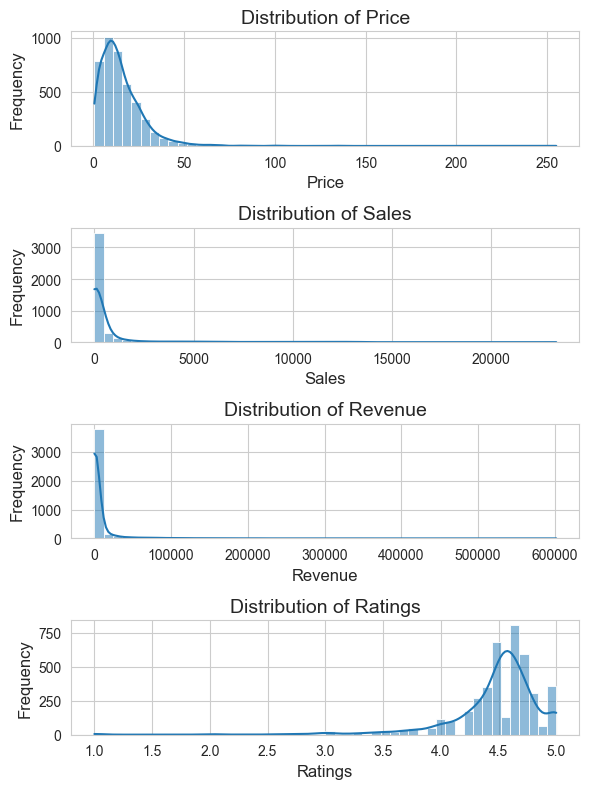

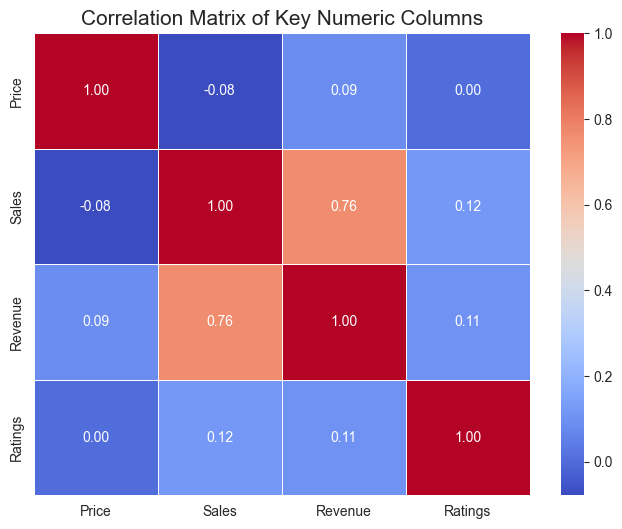

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of columns to visualize
columns_to_visualize = ['Price', 'Sales', 'Revenue', 'Ratings']

# Set the style
sns.set_style("whitegrid")

# Plot distributions for the selected columns
fig, axes = plt.subplots(nrows=len(columns_to_visualize), figsize=(6, 8))

for i, col in enumerate(columns_to_visualize):
    sns.histplot(data[col], ax=axes[i], kde=True, bins=50)
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

# Examine correlations between key numeric columns
correlation_matrix = data[columns_to_visualize].corr()

# Plotting the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Correlation Matrix of Key Numeric Columns", fontsize=15)
plt.show()

# Conclusion

**In this project, we performed comprehensive data cleaning and preprocessing on an Amazon grocery dataset. The steps included:**

1. Removing duplicates**

2. Handling missing values through imputation**

3. Text preprocessing for brand names**

4. Fuzzy matching to standardize inconsistent brand names**

5. Calculating missing Sales and Revenue**

6. Imputing categorical and numerical data**
 
The cleaned data is now ready for further analysis and visualization, ensuring consistency and completeness.**